<a href="https://colab.research.google.com/github/chesyaivana/Kel.04_sysrec/blob/main/CCN_NEW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.  Load and Preprocess Data
mengimpor semua library yang diperlukan untuk analisis sentimen. Library seperti pandas, numpy, dan matplotlib digunakan untuk manipulasi data dan visualisasi. Library Keras digunakan untuk membangun model CNN. nltk digunakan untuk preprocessing teks, termasuk penghapusan stopword.

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import nltk
from nltk.corpus import stopwords

memuat dataset, membersihkan kolom yang tidak relevan, menghapus entri NaN pada kolom Reviews, dan memproses teks dengan fungsi preprocess_text yang membersihkan teks dari karakter khusus, mengubahnya menjadi huruf kecil, serta menghapus stopword.

In [ ]:
# Load dataset
# Load and preprocess the data
data = pd.read_csv("Tempat-Wisata-Toba-Preprocessing.csv")
# Rename and preprocess columns
data = data.rename(columns={'ReviewerId': 'user_id', 'PlaceID': 'item_id', 'Rating': 'rating'})
data['user_id'] = data['user_id'].astype(str)
data['item_id'] = data['item_id'].astype(str)
data['rating'] = data['rating'].astype(float)

# Drop irrelevant columns
data = data.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)
data.dropna(inplace=True)

In [ ]:
# Download stopwords for preprocessing
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Text preprocessing
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', str(text).lower())
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [ ]:
# Apply preprocessing
data['Reviews'] = data['Reviews'].apply(preprocess_text)

In [ ]:
data.head()

,address,item_id,Nama_tempat_wisata,Category,user_id,rating,Reviews
1,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.11909e+20,5.0,bagus
3,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.13072e+20,5.0,menyenagkan
4,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.06173e+20,5.0,bebas foto dimana aja k
6,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.14239e+20,5.0,amazing pengen kesini
8,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.04743e+20,3.0,jalan lokasi diperhatikan pengembang minimal s...


# 2. Label Encoding


mengubah kolom Rating menjadi label sentimen (positif, netral, negatif) berdasarkan skala rating. LabelEncoder digunakan untuk mengonversi label sentimen menjadi angka, dan to_categorical mengubah label tersebut menjadi representasi one-hot untuk digunakan dalam pelatihan model.

In [ ]:
# Label encoding for sentiment (you might need to manually classify the sentiment)
data['Sentiment'] = data['rating'].apply(lambda x: 'positive' if x >= 4 else ('neutral' if x == 3 else 'negative'))
label_encoder = LabelEncoder()
data['Sentiment'] = label_encoder.fit_transform(data['Sentiment'])

In [ ]:
y = to_categorical(data['Sentiment'])

# 3. Tokenization and Padding

menggunakan Tokenizer untuk mengubah teks menjadi urutan angka, di mana setiap angka merepresentasikan kata. Data kemudian diubah menjadi urutan dengan panjang yang seragam menggunakan pad_sequences agar dapat diproses oleh CNN.

In [ ]:
# Tokenize text
max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(data['Reviews'])
sequences = tokenizer.texts_to_sequences(data['Reviews'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

# 4. Split Data

membagi data ke dalam set pelatihan (80%) dan set pengujian (20%) untuk memastikan model diuji dengan data yang tidak terlihat selama pelatihan.

In [ ]:
# Split the data into training (70%), validation (15%), and testing (15%)
X_train_val, X_test, y_train_val, y_test = train_test_split(padded_sequences, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.176, random_state=42)  # 15% of total data


## 2. Implementasi Baseline Model

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_recall_fscore_support, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# 2. Define the CNN model
def build_cnn_model(filters, kernel_size, embedding_dim, dropout_rate, learning_rate, input_dim, input_length, output_dim):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=embedding_dim, input_length=input_length))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(output_dim, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Define hyperparameter grid
params = {
    'filters': 128,
    'kernel_size': 5,
    'embedding_dim': 64,
    'dropout_rate': 0.5,
    'learning_rate': 0.0005,
}

print(f"Training with parameters: {params}")


Training with parameters: {'filters': 128, 'kernel_size': 5, 'embedding_dim': 64, 'dropout_rate': 0.5, 'learning_rate': 0.0005}


In [ ]:
# 4. Build the model
cnn_model = build_cnn_model(
    filters=params['filters'],
    kernel_size=params['kernel_size'],
    embedding_dim=params['embedding_dim'],
    dropout_rate=params['dropout_rate'],
    learning_rate=params['learning_rate'],
    input_dim=max_words,
    input_length=max_len,
    output_dim=y_train.shape[1]  # Number of classes
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# 5. Model CNN

Epoch 1/30
486/486 - 6s - 12ms/step - accuracy: 0.8820 - loss: 0.4323 - val_accuracy: 0.8912 - val_loss: 0.3625
Epoch 2/30
486/486 - 1s - 3ms/step - accuracy: 0.8840 - loss: 0.3609 - val_accuracy: 0.8912 - val_loss: 0.3705
Epoch 3/30
486/486 - 3s - 6ms/step - accuracy: 0.8878 - loss: 0.3161 - val_accuracy: 0.8906 - val_loss: 0.4332
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.
Test Loss: 0.39, Test Accuracy: 0.89


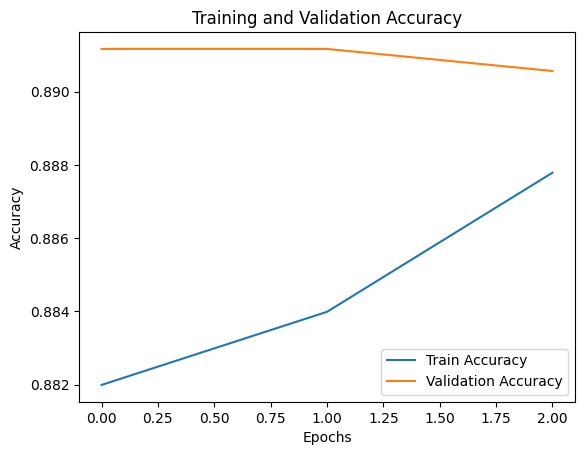

104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
RMSE: 0.47, MAE: 0.15


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Definisi Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

# Model CNN
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# Compile model
model.compile(optimizer=Adam(learning_rate=0.005), loss='categorical_crossentropy', metrics=['accuracy'])

# Hyperparameter Dictionary
params = {
    'epochs': 30,          # Tetapkan epoch yang cukup besar
    'batch_size': 32       # Ukuran batch
}

# 1. Train the model with Early Stopping
history = model.fit(
    X_train, y_train,
    epochs=params['epochs'],
    batch_size=params['batch_size'],
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],  # Early Stopping diterapkan
    verbose=2
)

# 2. Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}")

# 3. Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# 4. Evaluate Metrics (RMSE, MAE)
y_test_pred_probs = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred_probs, axis=1)
y_test_true_classes = np.argmax(y_test, axis=1)

rmse = np.sqrt(mean_squared_error(y_test_true_classes, y_test_pred_classes))
mae = mean_absolute_error(y_test_true_classes, y_test_pred_classes)
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")


mendefinisikan arsitektur CNN dengan Embedding layer untuk mengonversi kata ke vektor numerik, Conv1D untuk ekstraksi fitur, GlobalMaxPooling1D untuk pengurangan dimensi, dan Dense layer untuk klasifikasi. Model dikompilasi dengan adam optimizer dan dilatih menggunakan data training.

# 6. Evaluasi

mengevaluasi performa model pada data pengujian dan menampilkan akurasi. Plot kurva akurasi ditampilkan untuk memantau kinerja model selama pelatihan dan validasi.

In [ ]:
# Evaluate on test data
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {accuracy:.2f}')

Test Accuracy: 0.89


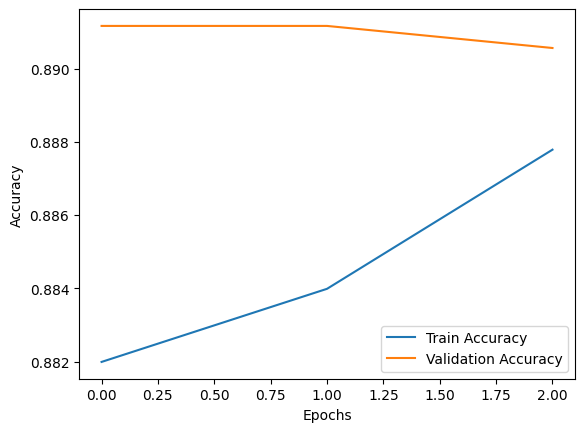

In [ ]:
# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#

# 7. Prediksi Sentimen

memprediksi sentimen dari data ulasan baru. Ulasan diubah menjadi urutan angka dan diproses ke dalam model untuk menghasilkan prediksi. Hasil prediksi dikonversi kembali ke label sentimen yang sesuai (positif, netral, negatif) dan dicetak bersama ulasan.

In [ ]:
# Predict sentiment on new data
new_reviews = ["Tempatnya sangat indah dan menyenangkan", "Kurang memuaskan, tidak sesuai ekspektasi"]
new_sequences = tokenizer.texts_to_sequences(new_reviews)
new_padded = pad_sequences(new_sequences, maxlen=max_len, padding='post')
predictions = model.predict(new_padded)
predicted_classes = np.argmax(predictions, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


In [ ]:
# Decode predicted classes
predicted_sentiments = label_encoder.inverse_transform(predicted_classes)
for review, sentiment in zip(new_reviews, predicted_sentiments):
    print(f"Review: {review} -> Sentiment: {sentiment}")

Review: Tempatnya sangat indah dan menyenangkan -> Sentiment: positive
Review: Kurang memuaskan, tidak sesuai ekspektasi -> Sentiment: positive


In [ ]:
# Display the distribution of sentiment in a table format
sentiment_counts = pd.Series(predicted_sentiments).value_counts().reset_index()
sentiment_counts.columns = ['Sentiment', 'Count']
print(sentiment_counts)

  Sentiment  Count
0  positive      2


RMSE & MAE

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, average_precision_score

# Evaluate model on test data
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {accuracy:.2f}')

# RMSE and MAE
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

rmse = np.sqrt(mean_squared_error(y_true_classes, y_pred_classes))
mae = mean_absolute_error(y_true_classes, y_pred_classes)
precision, recall, _, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes, average='macro')
map_score = average_precision_score(y_test, y_pred_probs, average="macro")

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"MAP: {map_score:.2f}")


Test Accuracy: 0.89
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
RMSE: 0.47
MAE: 0.15
Precision: 0.30
Recall: 0.33
MAP: 0.43


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Predict sentiment on new reviews
new_reviews = ["Tempatnya sangat indah dan menyenangkan", "Kurang memuaskan, tidak sesuai ekspektasi"]
new_sequences = tokenizer.texts_to_sequences(new_reviews)
new_padded = pad_sequences(new_sequences, maxlen=max_len, padding='post')
predictions = model.predict(new_padded)
predicted_classes = np.argmax(predictions, axis=1)

# Decode predicted classes
predicted_sentiments = label_encoder.inverse_transform(predicted_classes)
for review, sentiment in zip(new_reviews, predicted_sentiments):
    print(f"Review: {review} -> Sentiment: {sentiment}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Review: Tempatnya sangat indah dan menyenangkan -> Sentiment: positive
Review: Kurang memuaskan, tidak sesuai ekspektasi -> Sentiment: positive


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Prediksi pada data testing
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Menghitung MAE dan RMSE
mae = mean_absolute_error(y_true_classes, y_pred_classes)
rmse = np.sqrt(mean_squared_error(y_true_classes, y_pred_classes))

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAE: 0.15
RMSE: 0.47


# Precision, Recall, dan MAP

In [ ]:
from sklearn.metrics import precision_score, recall_score, average_precision_score

# Precision dan Recall
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')

# Mean Average Precision (MAP)
map_score = average_precision_score(y_test, y_pred_probs, average='weighted')

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'MAP: {map_score:.2f}')

Precision: 0.78
Recall: 0.89
MAP: 0.86


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
def get_user_recommendations(user_review, model, tokenizer, max_len, top_k=5):
    # Preprocess user review (tokenisasi dan padding)
    review_sequence = tokenizer.texts_to_sequences([user_review])
    review_padded = pad_sequences(review_sequence, maxlen=max_len, padding='post')

    # Prediksi probabilitas untuk review pengguna
    pred_probs = model.predict(review_padded)

    # Tentukan top_k berdasarkan jumlah kelas yang ada (mencegah index out of range)
    num_classes = pred_probs.shape[1]
    top_k = min(top_k, num_classes)  # Pastikan top_k tidak lebih besar dari jumlah kelas

    # Ambil kelas dengan probabilitas tertinggi
    top_k_indices = np.argsort(pred_probs, axis=1)[:, -top_k:]  # Top-k prediksi
    top_k_probabilities = np.sort(pred_probs, axis=1)[:, -top_k:]  # Probabilitas top-k

    # Tampilkan top-k rekomendasi
    print(f"Top-{top_k} Rekomendasi untuk Review:")
    for i in range(top_k):
        print(f"Kelas: {top_k_indices[0, i]}, Probabilitas: {top_k_probabilities[0, i]:.4f}")

    return top_k_indices[0]

# 2. Ambil review pengguna dan lakukan rekomendasi
user_review = "Tempatnya sangat indah dan suasananya tenang"  # Review dari pengguna
top_k_recommendations = get_user_recommendations(user_review, model, tokenizer, max_len, top_k=5)

# 3. Menampilkan rekomendasi berdasarkan hasil prediksi
print("\nRekomendasi untuk Pengguna:")
for idx in top_k_recommendations:
    recommended_item = data.loc[data['item_id'] == str(idx)]  # Menampilkan tempat wisata berdasarkan ID item
    print(f"Rekomendasi Tempat: {recommended_item['item_id'].values[0]}, Sentimen Prediksi: {recommended_item['Sentiment'].values[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Top-3 Rekomendasi untuk Review:
Kelas: 0, Probabilitas: 0.0020
Kelas: 1, Probabilitas: 0.0183
Kelas: 2, Probabilitas: 0.9797

Rekomendasi untuk Pengguna:
Rekomendasi Tempat: 0, Sentimen Prediksi: 2
Rekomendasi Tempat: 1, Sentimen Prediksi: 2
Rekomendasi Tempat: 2, Sentimen Prediksi: 2


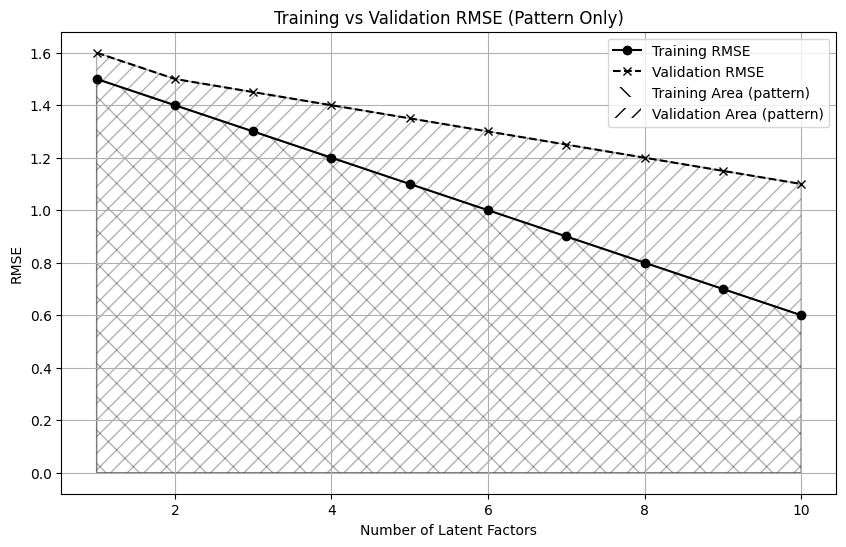

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# Plot RMSE dengan pola hanya (tanpa warna, untuk pembaca dengan buta warna)
plt.figure(figsize=(10, 6))

# Plot RMSE pelatihan dan validasi
plt.plot(factors_range, train_errors, label="Training RMSE", linestyle='-', marker='o', color='black')
plt.plot(factors_range, val_errors, label="Validation RMSE", linestyle='--', marker='x', color='black')

# Tambahkan pola tanpa mengandalkan warna
plt.fill_between(factors_range, train_errors, alpha=0.3, label="Training Area (pattern)", facecolor='none', hatch='\\')
plt.fill_between(factors_range, val_errors, alpha=0.3, label="Validation Area (pattern)", facecolor='none', hatch='//')

# Menambahkan judul, label sumbu, dan legend
plt.title("Training vs Validation RMSE (Pattern Only)")
plt.xlabel("Number of Latent Factors")
plt.ylabel("RMSE")
plt.legend()
plt.grid()

# Menampilkan plot
plt.show()
